# Gliederung

<!-- 
    Frame the problem and look at the big picture.
    Get the data.
    Explore the data to gain insights.
    Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
    Explore many different models and short-list the best ones.
    Fine-tune your models and combine them into a great solution.
    Present your solution.
    Launch, monitor, and maintain your system.
-->

1. [Aufgabenstellung](#1-problem--aufgabenstellung)
2. [Import](#2-import)
3. [Exploration](3-#exploration).
4. [Vorbereitung / Feauture Engineering]()
5. [Modellierung]()
6. [Ergebnis]()


# 1. Problem / Aufgabenstellung

<!-- Frame the problem and look at the big picture. -->

Kategorien der Verbrechen in San Francisco sollen vorhergesagt werden.
Dabei werden die Kategorien *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* betrachtet

Zur Vorhersage soll **eine** dieser Methoden verwendet werden: Regression, Klassifikation oder Clustering



# 2. Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
colors = sns.color_palette(None, 5)
import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot as gplt
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
from shapely.geometry import Point
from shapely.geometry import Polygon, MultiPolygon

from itertools import product
from scipy import stats

from sklearn import tree
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\sampleSubmission.csv
data\SF Find Neighborhoods.geojson
data\test.csv
data\train.csv


In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.head()


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
train['Dates'] = pd.to_datetime(train['Dates'])

print('First date: ', str(train['Dates'].min()))
print('Last date: ', str(train['Dates'].max()))
print('Train data shape: ', train.shape)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
Train data shape:  (878049, 9)


# 3. Exploration

## Selektion

Die Daten werden so gefiltert, dass nur *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* als Kategorien vertreten sind.

In [4]:
train["Category"].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [5]:
categories = [i.upper() for i in ["Larceny/Theft", "Assault", "Drug/Narcotic", "Vehicle Theft", "Burglary"]]

train = train.loc[train["Category"].isin(categories)]

train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564


## Datentypen

In [6]:
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

Hier kann man einige Datentypen konvertieren:

Dates -> DateTime
Category -> String
Descript -> String
DayOfWeek -> String
PdDistrict -> String
Resolution -> String

neue Spalte für CategoryID als Integer
neue Spalte für PdDisctrictID als Integer
neue Spalte für DayOfWeekID als Integer
neue Spalte für ResolutionID als Integer

In [7]:
train["Dates"] = pd.to_datetime(train["Dates"])
train["YearMonth"] = train['Dates'].dt.strftime('%Y-%m')
train["Year"] = train['Dates'].dt.strftime('%Y')
train["Month"] = train['Dates'].dt.strftime('%m')
train["Day"] = train['Dates'].dt.strftime('%d')
train["TimeOfDay"] = train['Dates'].dt.strftime('%H')
train["DayOfWeekId"] = train['Dates'].dt.weekday + 1

## Duplikate


In [8]:
train.duplicated().sum()

923

In [9]:
train.drop_duplicates(inplace=True)

## Koordinaten

Im nächsten Schritt wird betrachtet, ob die Koordinaten falsche Werte enthalten könnten.

C:\Users\fried\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\fried\AppData\Local\Temp\ipykernel_2008\1251819745.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


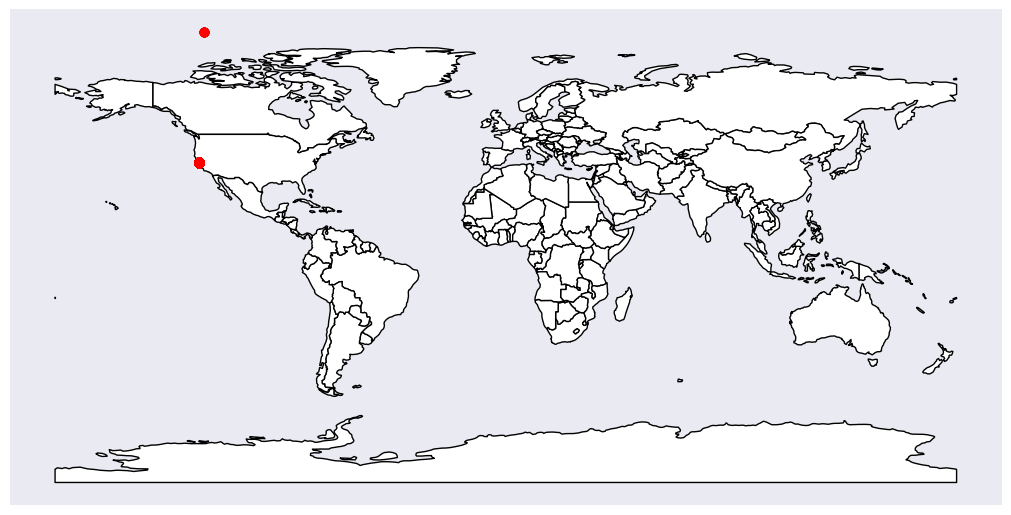

In [10]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(10, 10), layout='constrained')

world.plot(ax=ax, color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')

ax.set_aspect('equal', adjustable='box')

sns.despine(ax=ax, left=True, right=True, top=True, bottom=True)

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

# ax.set_xlim(0,9 * min(train_gdf["X"]), 1,1 * max(train_gdf["X"]))
# ax.set_ylim(0,9 * min(train_gdf["Y"]), 1,1 * max(train_gdf["Y"]))

plt.show()

Ein Blick auf die Karte genügt um zu sehen, dass sich einige Punkte außerhalb der USA und außerhalb von San Fransisco befinden.

In [11]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
train_gdf.loc[train_gdf.Y > 50].sample(5)

29


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,Year,Month,Day,TimeOfDay,DayOfWeekId,Coordinates
677828,2005-10-05 12:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,VANNESS AV / BEACH ST,-120.5,90.0,2005-10,2005,10,05,12,3,POINT (-120.50000 90.00000)
833921,2003-08-06 12:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90.0,2003-08,2003,08,06,12,3,POINT (-120.50000 90.00000)
842261,2003-06-25 07:30:00,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Wednesday,RICHMOND,NONE,JOHN F KENNEDY DR / MARTIN LUTHER KING JR DR,-120.5,90.0,2003-06,2003,06,25,07,3,POINT (-120.50000 90.00000)
673078,2005-10-23 20:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,RICHMOND,NONE,AVENUE OF THE PALMS / GEARY BL,-120.5,90.0,2005-10,2005,10,23,20,7,POINT (-120.50000 90.00000)
842828,2003-06-23 19:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,NORTHERN,NONE,LARKIN ST / AUSTIN ST,-120.5,90.0,2003-06,2003,06,23,19,1,POINT (-120.50000 90.00000)


In [12]:
from sklearn.impute import SimpleImputer

In [13]:


train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])

train_gdf = create_gdf(train)

C:\Users\fried\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Fehlende Werte

In [14]:
train.isnull().sum()

Dates          0
Category       0
Descript       0
DayOfWeek      0
PdDistrict     0
Resolution     0
Address        0
X              0
Y              0
YearMonth      0
Year           0
Month          0
Day            0
TimeOfDay      0
DayOfWeekId    0
dtype: int64

Wie oben zu sehen, gibt es keine fehlenden Werte in diesem Datensatz



## Korrelation der Spalten



C:\Users\fried\AppData\Local\Temp\ipykernel_2008\2401544524.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([truncate_label(label.get_text()) for label in ax.get_xticklabels()])


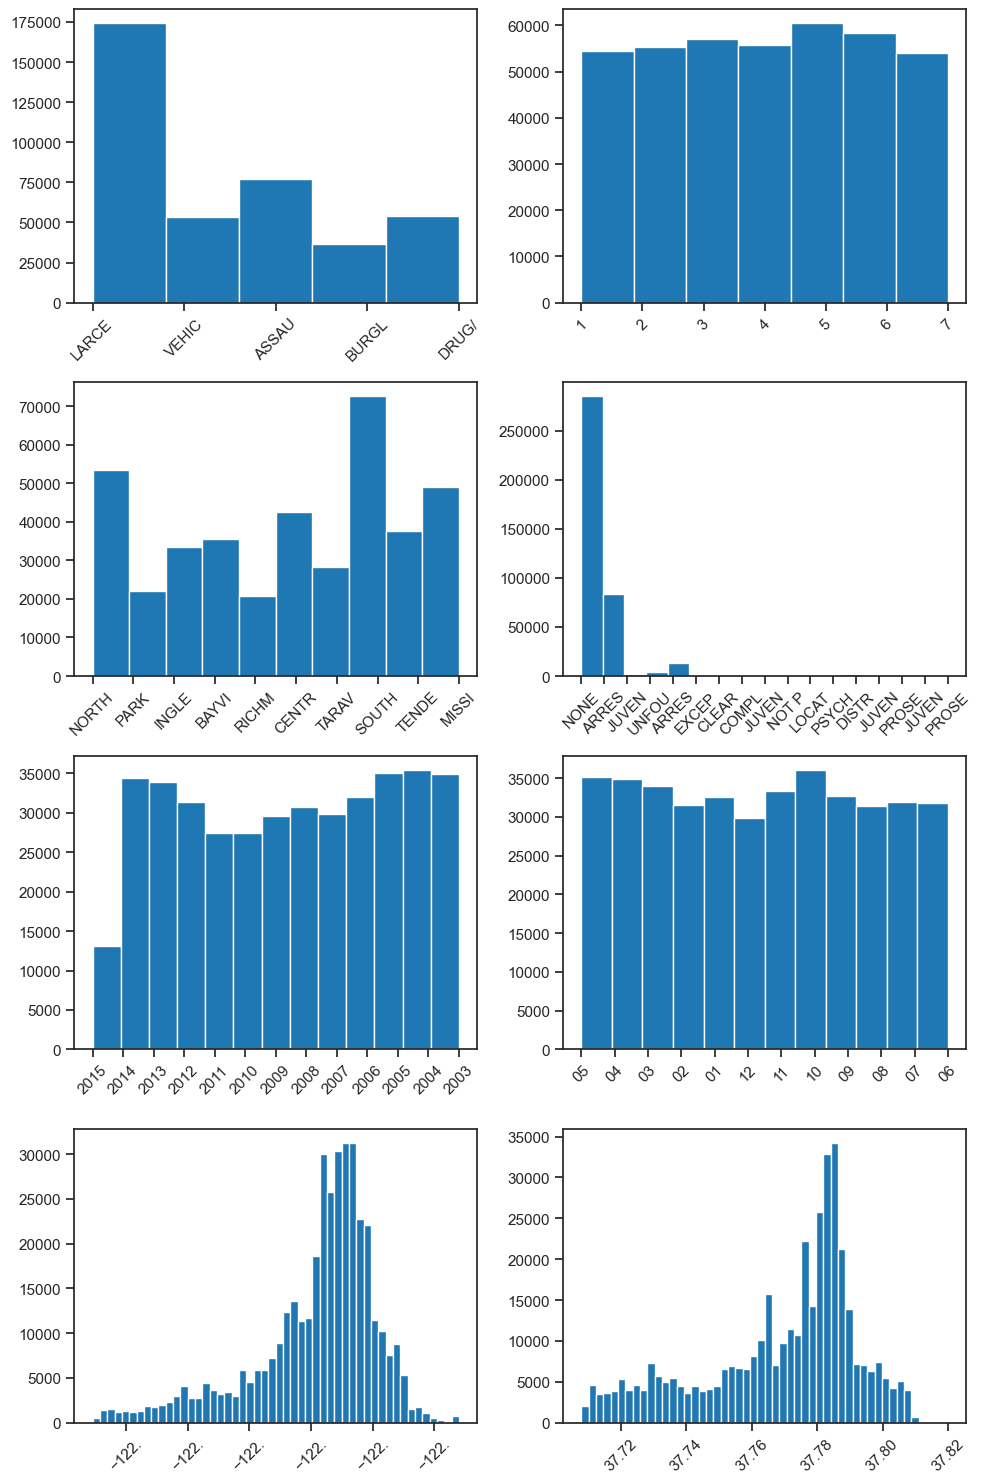

In [36]:


def truncate_label(label, length=5):
    return label[:length]

colors = sns.color_palette(None, 3)
columns = ["DayOfWeek", "PdDistrict", "Resolution"]


fig, axes = plt.subplots(4, 2, figsize = (10, 15), tight_layout=True)

axes[0, 0].hist(train["Category"], bins=5, align="mid")
axes[0, 1].hist(train["DayOfWeekId"], bins=7, align="mid")
axes[1, 0].hist(train["PdDistrict"], align="mid", bins=len(train["PdDistrict"].unique()))
axes[1, 1].hist(train["Resolution"], align="mid", bins=len(train["Resolution"].unique()))
axes[2, 0].hist(train["Year"], bins=13, align="mid")
axes[2, 1].hist(train["Month"], bins=12, align="mid")
axes[3, 0].hist(train["X"], align="mid", bins=50)
axes[3, 1].hist(train["Y"], align="mid", bins=50)

# Rotate x-axis tick labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_ticks_position('bottom')  # Place ticks at the bottom for better visibility
    ax.set_xticklabels([truncate_label(label.get_text()) for label in ax.get_xticklabels()])

plt.tight_layout()

plt.show()

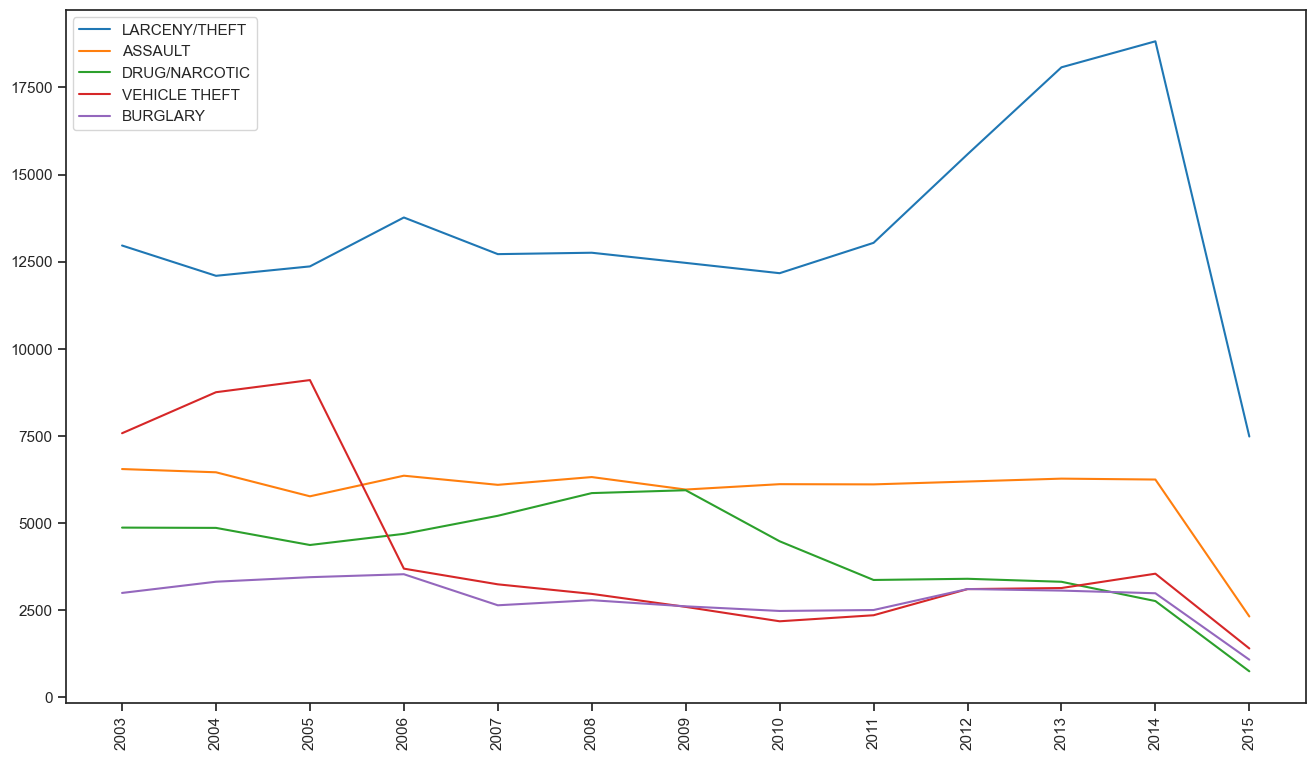

In [16]:
sns.set_style("ticks")
sns.set_context('notebook', font_scale = 1)

train_year_cat = train.groupby(by=["Year", "Category"], as_index=False).count()
data = train_year_cat.pivot_table(index="Year", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix, rotation=90, ha="center")
plt.show()


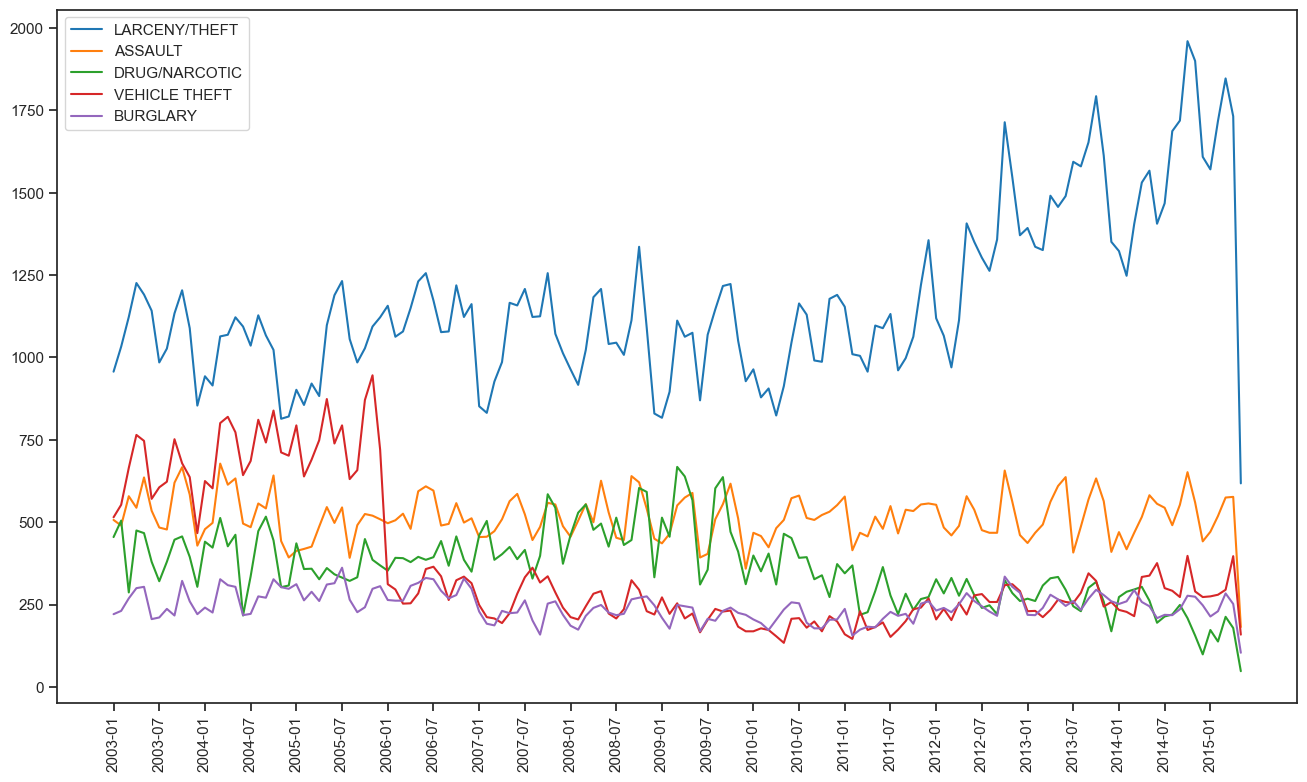

In [17]:
train_yearmonth_cat = train.groupby(by=["YearMonth", "Category"], as_index=False).count()
data = train_yearmonth_cat.pivot_table(index="YearMonth", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix[::6], rotation=90, ha="center")
plt.show()

In [18]:


sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})

geometry = [Point(xy) for xy in zip(train.X, train.Y)]
train_gdf = GeoDataFrame(train, crs="EPSG:4326", geometry=geometry)


point = train_gdf
poly  = sf_df

pointInPolys = sjoin(point, poly, how='left')
grouped = pointInPolys.groupby('index_right').count()

C:\Users\fried\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\fried\AppData\Local\Temp\ipykernel_2008\4042753423.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  pointInPolys = sjoin(point, poly, how='left')


In [19]:
heat_districts = pointInPolys.groupby('index_right')["Dates"].count()
heat_districts

index_right
0.0       239
1.0       450
2.0        36
3.0       465
4.0      5046
         ... 
112.0     579
113.0     591
114.0    1664
115.0     226
116.0     191
Name: Dates, Length: 117, dtype: int64

In [20]:

geom = sf_df.pop('geometry')
sf_df = sf_df.join(geom, how='inner')
sf_df["polygons"] = ""
for i,row in sf_df.iterrows():
    geometry = row["geometry"]
    if geometry.geom_type == 'MultiPolygon':
        polygons = []
        for polygon in geometry.geoms:
            exterior_coords = list(polygon.exterior.coords)
            interior_coords = [list(interior.coords) for interior in polygon.interiors]
            polygons.append(Polygon(exterior_coords, interior_coords))
    else:
        polygons = [Polygon(list(geometry.exterior.coords))]
    sf_df.at[i, "polygons"] = polygons

sf_df["polygons"] = sf_df["polygons"].explode()

sf_df["index_right"] = sf_df.index
sf_df["heat"] = sf_df.merge(heat_districts, on="index_right")["Dates"]
sf_df["geometry"] = sf_df["polygons"]

gdf = gpd.GeoDataFrame(sf_df)




C:\Users\fried\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


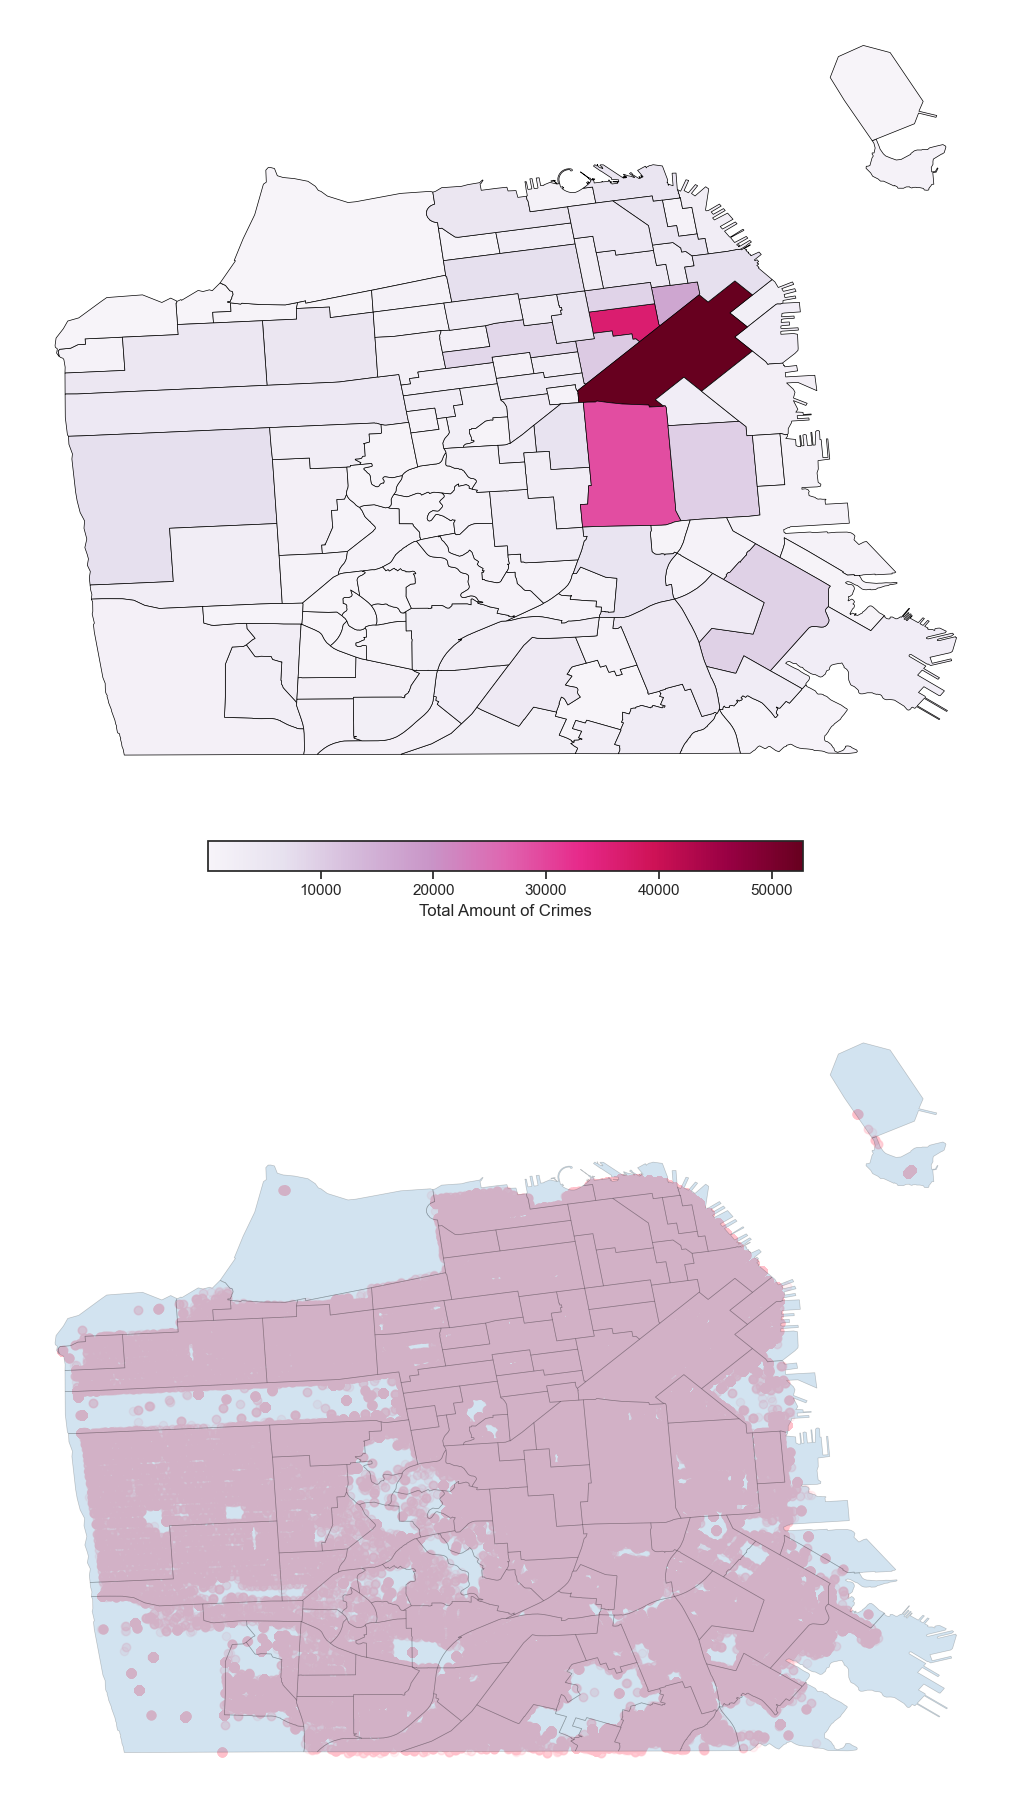

In [21]:
fig, ax = plt.subplots(2,1,figsize=(10, 20), sharey=True, layout='constrained')

gdf.plot(ax=ax[0], alpha=1, edgecolor='k', linewidth=0.5, column="heat", cmap="PuRd")
cbar = plt.colorbar(ax[0].get_children()[0], ax=ax[0], orientation="horizontal", shrink=0.6)
cbar.set_label("Total Amount of Crimes")

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})
sf_df.plot(ax=ax[1], alpha=0.2, edgecolor='k', linewidth=0.5, zorder=2)
ax[1].scatter(data=train.loc[train["Y"]<80], x="X", y="Y",alpha=0.2, color="pink", zorder=1)

ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

sns.despine(ax=ax[0], left=True, right=True, top=True, bottom=True)
sns.despine(ax=ax[1], left=True, right=True, top=True, bottom=True)

ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])

ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])    
    
plt.show()



In [22]:
df_district_cat = pd.crosstab(train['Category'], train['PdDistrict'])
df_district_cat.head()

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ASSAULT,9845,6971,8522,11146,8312,3512,3198,12175,5460,7674
BURGLARY,3914,4499,3327,3736,5827,2875,2683,4796,3459,1484
DRUG/NARCOTIC,4496,1805,2372,8750,4508,2570,999,9222,1529,17668
LARCENY/THEFT,10075,24973,10207,18201,28566,9118,9845,41660,11807,9868
VEHICLE THEFT,7199,4208,8950,7134,6286,3955,4114,4722,6133,1005


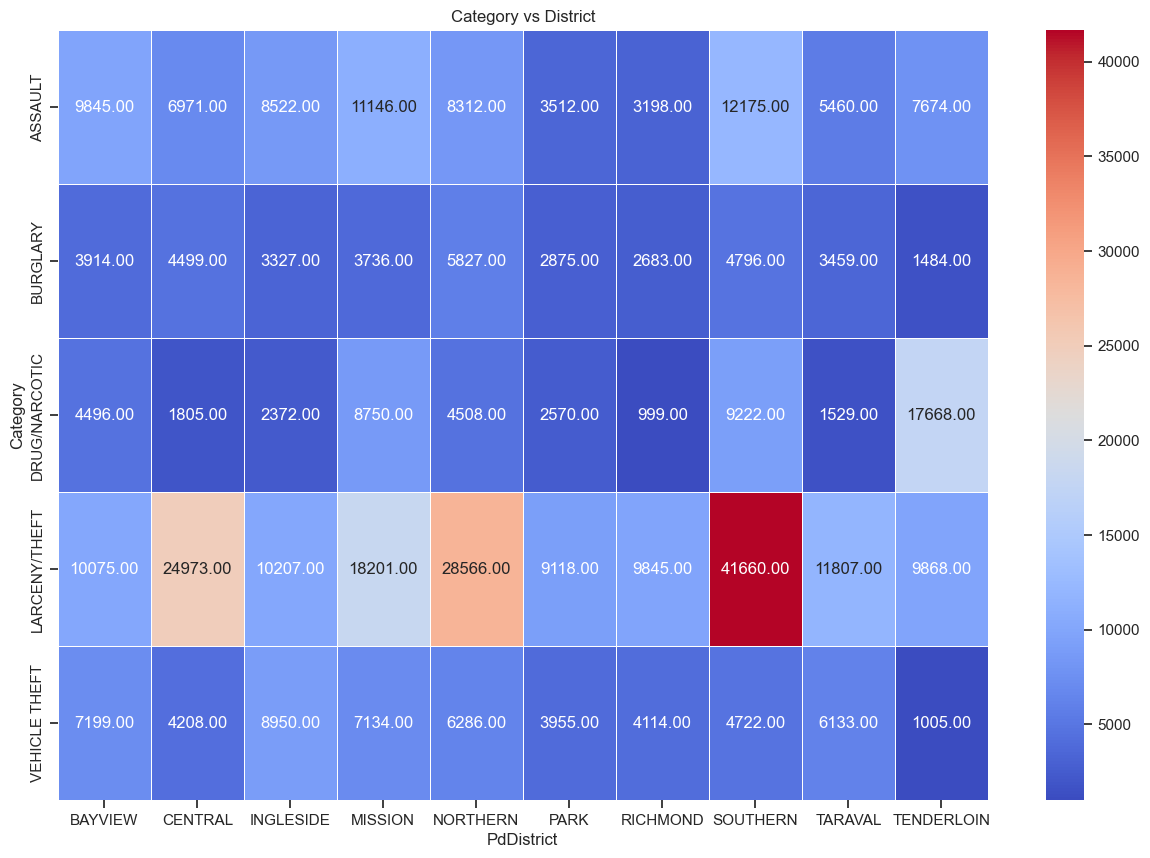

In [23]:

plt.figure(figsize=(15, 10))
sns.heatmap(df_district_cat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Category vs District')
plt.show()

In [38]:
unique_val_col = pd.DataFrame(train.nunique())
corr_columns = list(unique_val_col.loc[unique_val_col[0] <= 250].index)
corr_columns.remove("DayOfWeekId")
print(corr_columns)

['Category', 'DayOfWeek', 'PdDistrict', 'Resolution', 'YearMonth', 'Year', 'Month', 'Day', 'TimeOfDay']


In [25]:

x = [i[0] for i in product(corr_columns, corr_columns)]
y = [i[1] for i in product(corr_columns, corr_columns)]


corr_df = pd.DataFrame(index=corr_columns, columns=corr_columns)

for i in range(0,len(x)):
    if x[i] == y[i]:
        corr_df.loc[x[i], y[i]] = 1
        corr_df.loc[y[i], x[i]] = 1
    if pd.isnull(corr_df.loc[x[i], y[i]]):
        temp_ct = pd.crosstab(train[x[i]], train[y[i]])
        
        X2 = stats.chi2_contingency (temp_ct, correction= False )[0]
        n = sum(temp_ct.sum())
        minDim = min( temp_ct.shape )-1
        
        #calculate Cramer's V
        V = np.sqrt((X2/n) / minDim)
        
        corr_df.loc[x[i], y[i]] = V
        corr_df.loc[y[i], x[i]] = corr_df.loc[x[i], y[i]]

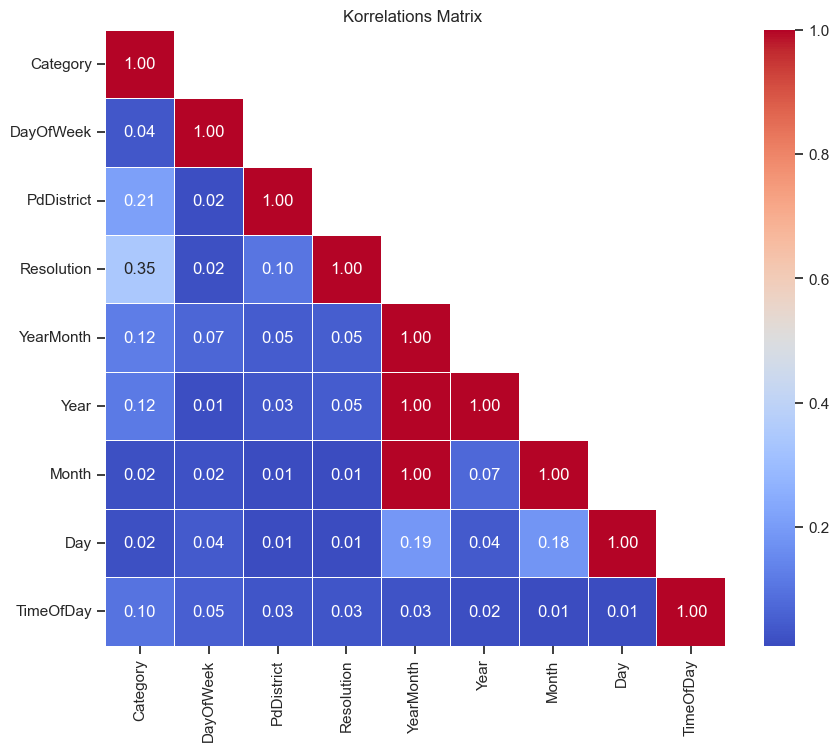

In [26]:
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Korrelations Matrix ')
plt.show()

In [27]:
data_cat = train.groupby('Category').count().iloc[:, 0]. sort_values(ascending=False)
data = data_cat.reindex(np.append(np.delete(data_cat.index, 1), 'OTHER OFFENSES'))



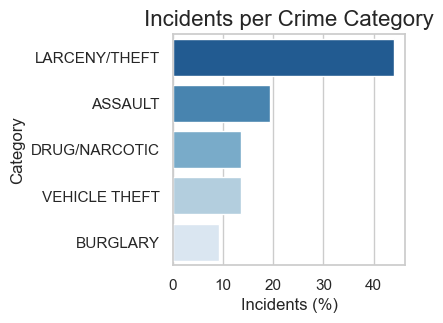

In [28]:
plt.figure(figsize=(3, 3))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x = (data_cat.values / data_cat.values.sum()) * 100,
        y = data_cat.index,
        orient='h',
        palette="Blues_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

# 4. Vorbereitung

Anhand der Korrelation können wir ablesen, welche Spalten den größten Einfluss auf die Kategorie hat, welche wir letztendlich vorhersagen wollen.

In [29]:
corr_df["Category"]



Category      1.000000
DayOfWeek     0.035553
PdDistrict    0.213927
Resolution    0.346102
YearMonth     0.123634
Year          0.116026
Month         0.018412
Day           0.018449
TimeOfDay     0.099247
Name: Category, dtype: float64

Im nächsten Schritt werden die Spalten ausgewählt, welche mindestens eine Korrelation von 0.05 haben


Da Year und YearMonth fast die gleiche Korrelation mit Category haben und untereinander eine sehr hohe Korrelation haben, 
beschränken wir uns auf YearMonth und filtern Year raus. 

Resolution ist leider nicht in den Test-Daten vorhanden, daher nützt es nichts die Modelle mit dieser Spalte zu trainieren und sie wird ebenfalls entfernt. 
Und da wir Category vorhersagen sollen, wird es auch im Training nicht berücksichtigt

In [41]:
onehot_cols = list(corr_df["Category"].loc[corr_df["Category"] >= 0.05].index)
onehot_cols.remove("Year")
onehot_cols.remove("Resolution")
onehot_cols.remove("Category")
onehot_cols

['PdDistrict', 'YearMonth', 'TimeOfDay']

## One-Hot-Encoding

In [44]:
train_dummies = pd.get_dummies(data=train, columns=onehot_cols, dtype=float, prefix=["_" + i for i in onehot_cols])
train_dummies.head()

,Dates,Category,Descript,DayOfWeek,Resolution,Address,X,Y,Year,Month,...,_TimeOfDay_14,_TimeOfDay_15,_TimeOfDay_16,_TimeOfDay_17,_TimeOfDay_18,_TimeOfDay_19,_TimeOfDay_20,_TimeOfDay_21,_TimeOfDay_22,_TimeOfDay_23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015,05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Für Clustering Algorithmen müssen die Daten skaliert werden

In [47]:
from sklearn.preprocessing import StandardScaler
train_dummies_scaled = train_dummies.copy()
train_dummies_scaled[list(train_dummies.filter(like='_', axis=1).columns)] = StandardScaler().fit_transform(train_dummies[list(train_dummies.filter(like='_', axis=1).columns)])
train_dummies_scaled.head()

,Dates,Category,Descript,DayOfWeek,Resolution,Address,X,Y,Year,Month,...,_TimeOfDay_14,_TimeOfDay_15,_TimeOfDay_16,_TimeOfDay_17,_TimeOfDay_18,_TimeOfDay_19,_TimeOfDay_20,_TimeOfDay_21,_TimeOfDay_22,_TimeOfDay_23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,05,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,05,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015,05,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015,05,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015,05,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658


## Aufteilung in Trainings- und Test-Daten

In [48]:
X, y = train_dummies.filter(like='_', axis=1), train_dummies["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# 5. Modellierung

Bevor wir in die Modellierung tiefer einsteigen blicken wir einmal grob auf die möglichen Modelle und betrachten deren Genauigkeit bei Standardeinstellungen

## Decision Tree

In [49]:
dt_clf = tree.DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, dt_clf.predict(X_test))

0.4386022733369613

In [36]:
# Output: ACHTUNG, SEHR SEHR LANGSAM 

# feature_names = list(train_dummies.filter(like='_', axis=1).columns)
# feature_names = [i.split("_")[2] for i in feature_names]

# tree.plot_tree(
#     clf,
#     proportion=True,
#     feature_names=feature_names,
#     class_names=list(clf.classes_),
#     label="none",
#     filled=True,
#     impurity=False
# )
# plt.figure(figsize=(10,20))
# plt.rcParams["figure.dpi"] = 300
# plt.show()

## K-Nearest-Neighbors (kNN)

In [71]:
from sklearn.neighbors import KNeighborsClassifier
X, y = train_dummies_scaled.filter(like='_', axis=1), train_dummies_scaled["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

knn_clf = KNeighborsClassifier(algorithm="ball_tree", n_neighbors=3)
knn_clf.fit(X_train, y_train)

#Der Predictor braucht sehr sehr lange, daher wurde nur mit 500 Zeilen gearbeitet
sample_index = list(y_test.sample(500, random_state=1).index)
accuracy_score(y_test.loc[sample_index], knn_clf.predict(X_test.loc[sample_index]))

0.346

## Support Vector Machines

In [50]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

svm_clf = LinearSVC(dual="auto", random_state=0, tol=1e-5)
svm_clf.fit(X_train, y_train)

accuracy_score(y_test, svm_clf.predict(X_test))

0.47182089231924823

## Zwischenfazit

Nach grober Betrachtung der Genauigkeiten der Modelle gibt es einen vorläufigen Gewinner

<br>

| Model                   | Genauigkeit |
|-------------------------|-------------|
| Support Vector Machines | 0.472       |
| Decision Tree           | 0.439       |
| K-Nearest-Neighbors     | 0.364       |

# 6. Ergebnis